# Producing single peaked, skewed idealised profiles
## Background
It is standard practice in flood modelling to use design rainfall profiles generated by FEH/ReFH2. We are interested in examining whether distributing rainfall over time in multiple peaks, rather than just one, will result in a different flooding outcome. 

## Constructing synthetic multiple peaked events
The FEH single-peak profiles are always produced with a single peak which can be characterised by:
1) The total corresponding rainfall volume $V$.  
2) The duration $d$ (start to end).  
3) The shape of the peak, defined here: https://refhdocs.hydrosolutions.co.uk/Design-DDF-Rainfall-Hyetographs/Design-Storm-Profiles/  

TBC....

In [18]:
from datetime import datetime, timedelta
import pandas as pd
from dateutil.relativedelta import relativedelta
import sys
import matplotlib.patches as mpatches
from matplotlib import dates as mdates
import re
sys.path.insert(1, '../')
from Functions import *

### Define the different methods 

In [28]:
methods =['6h_sp_fl_0.1', '6h_sp_fl_0.2', '6h_sp_fl_0.3', '6h_sp_fl_0.4','6h_sp_c_0.5',
          '6h_sp_bl_0.6','6h_sp_bl_0.7','6h_sp_bl_0.8','6h_sp_bl_0.9']
durations = ['1h', '3h', '6h']

### Create dataframe for one method containing the accumulation and rate at each minute of time

In [20]:
N_subpeaks = 1
# For each method produce a dataframe containing precipitation values for each minute and save these to file
for duration in ['6h']:
    for method in methods:
        ## PARAMETER SETTINGS
        total_duration_minutes= int(duration[0]) * 60
        subpeak_duration_minutes=total_duration_minutes/6
        if duration == '1h':
            total_mm_accum= 38.7
        elif duration == '3h':
            total_mm_accum= 51.3
        elif duration == '6h':
              total_mm_accum=59.98
        default_peak_shape='refh2-summer'
        
        # Get profile peak before frac parameter
        if len(re.findall("\d+\.\d+", method))>0:
            peak_before_frac = float(re.findall("\d+\.\d+", method)[0])
        else:
            peak_before_frac = 0.5
        print(peak_before_frac)
        
        # Create datetimes to go with values
        start = datetime(2022,8,1,0,0,0)
        end = start + relativedelta(hours=int(duration[0]))
        end = end - timedelta(minutes=1) 
        seconds = (end - start).total_seconds() + 60
        step = timedelta(minutes=1)
        datetimes = []
        for i in range(0, int(seconds), int(step.total_seconds())):
            datetimes.append(start + timedelta(seconds=i))       
        
        # Find accumulation and rate
        accum, rate = calc_rainfall_curves(method,total_mm_accum,total_duration_minutes,N_subpeaks,subpeak_duration_minutes,peak_before_frac)
        # Create as dataframe
        accum_df = pd.DataFrame({'Dates': datetimes,  'Rate (mm/hr)': rate, 'Rate (mm/min)': rate/60})
        print(method, accum_df['Rate (mm/min)'].max())
        # Keep only columns needed for feeding to ReFH2
        accum_df = accum_df[['Dates','Rate (mm/min)']]
        
        print(accum_df['Rate (mm/min)'].sum())
        
        # Write to csv
        accum_df.to_csv("{}r_100yrRP/PreLossRemoval/{}.csv".format(duration, method),header = False, index = False)
        print("{}r_100yrRP/PreLossRemoval/{}.csv".format(duration, method))

0.1
6h_sp_fl_0.1 1.2292471591740357
59.98
6hr_100yrRP/PreLossRemoval/6h_sp_fl_0.1.csv
0.2
6h_sp_fl_0.2 1.2015023049051499
59.98
6hr_100yrRP/PreLossRemoval/6h_sp_fl_0.2.csv
0.3
6h_sp_fl_0.3 1.170656098416444
59.98
6hr_100yrRP/PreLossRemoval/6h_sp_fl_0.3.csv
0.4
6h_sp_fl_0.4 1.1358180431589524
59.98
6hr_100yrRP/PreLossRemoval/6h_sp_fl_0.4.csv
0.5
6h_sp_c_0.5 1.0956277117199775
59.980000000000004
6hr_100yrRP/PreLossRemoval/6h_sp_c_0.5.csv
0.6
6h_sp_bl_0.6 1.135818043158956
59.980000000000004
6hr_100yrRP/PreLossRemoval/6h_sp_bl_0.6.csv
0.7
6h_sp_bl_0.7 1.170656098416444
59.97999999999999
6hr_100yrRP/PreLossRemoval/6h_sp_bl_0.7.csv
0.8
6h_sp_bl_0.8 1.2015023049051479
59.98
6hr_100yrRP/PreLossRemoval/6h_sp_bl_0.8.csv
0.9
6h_sp_bl_0.9 1.2292471591740366
59.98
6hr_100yrRP/PreLossRemoval/6h_sp_bl_0.9.csv


### Create a dataframe sepecifying the volume of rainfall within each 5th of the event
Also the max value in each 5th (to check whether the fifth where the peak in intensity occurs, is the same as where the greatest volume is)

In [21]:
breaks = range(0,360,72)
rainfall_volume_df = pd.DataFrame()
rainfall_peak_df = pd.DataFrame()

for num, method in enumerate(methods):
    # Read in post loss removal rainfall data
    post_loss_removal = pd.read_csv('../IdealisedProfiles/' + "6hr_100yrRP/PostLossRemoval/{}_urban.csv".format(method))
    # Format time column
    post_loss_removal = clean_dfs(post_loss_removal)
    # Create a list containing the total rainfall rate in each chunk of time 
    rainfall_volume_ls =[]
    rainfall_peak_ls = []
    for i in breaks:
        rainfall_volume_ls.append(post_loss_removal.iloc[i:(i+72)]['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'].sum())
        rainfall_peak_ls.append(post_loss_removal.iloc[i:(i+72)]['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'].max())
    rainfall_volume_df[method] = rainfall_volume_ls
    rainfall_peak_df[method] = rainfall_peak_ls
    
rainfall_volume_df.loc['Total']= rainfall_volume_df.sum()

## Plot pre loss removal profiles

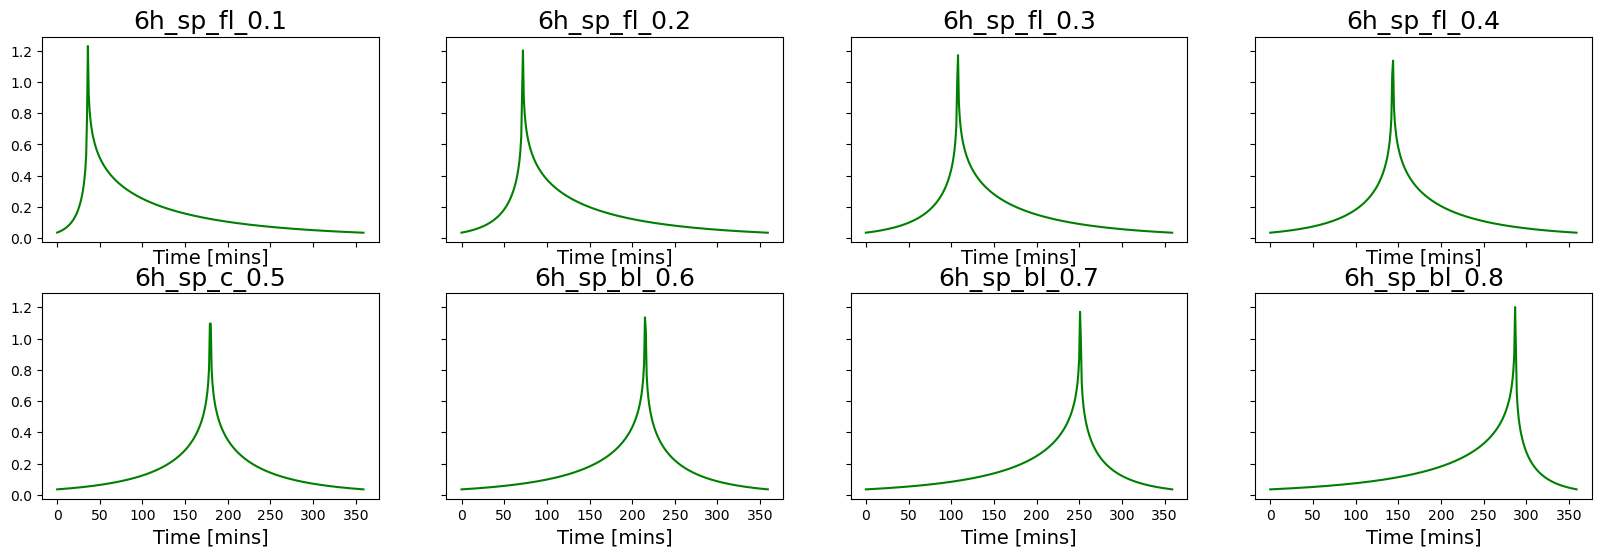

In [22]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize = (20,6), sharex = True, sharey = True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.25)

for number, ax in enumerate(axs.reshape(-1)): 
    plot_profile_shape_prelossremoval(ax, methods[number], "../IdealisedProfiles/")

## Plot post loss removal profiles 

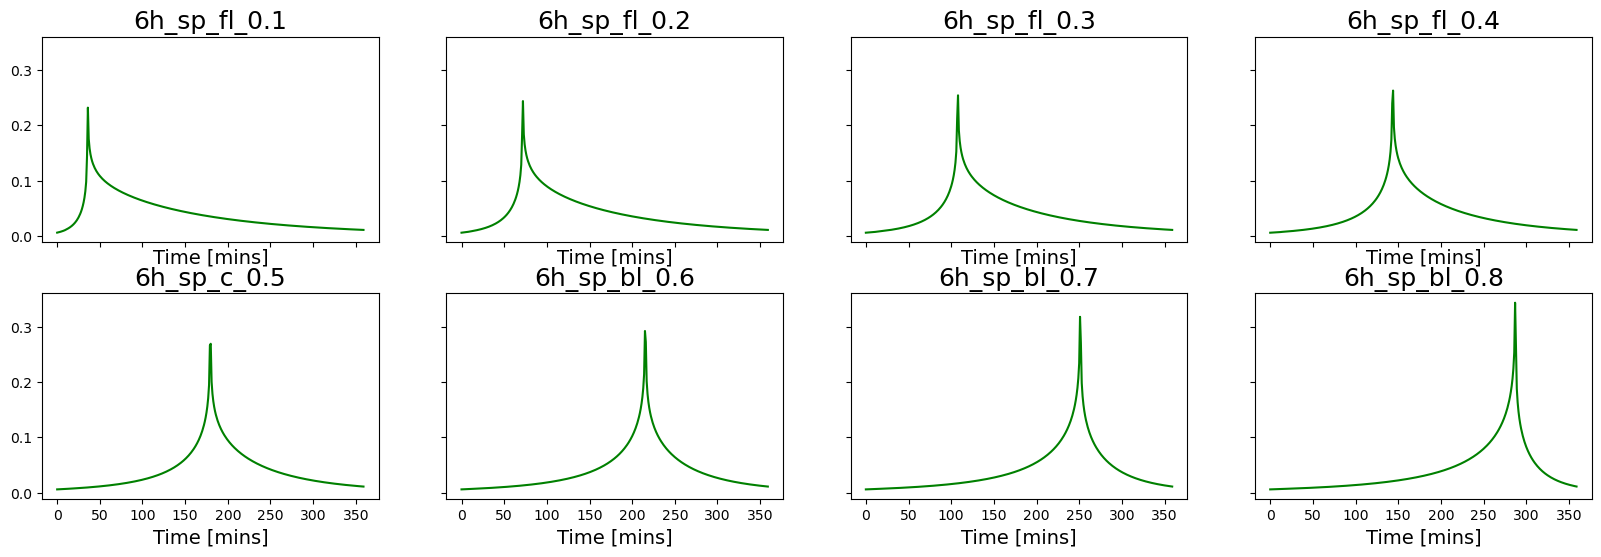

In [23]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize = (20,6), sharex = True, sharey = True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.25)

for number, ax in enumerate(axs.reshape(-1)): 
    plot_profile_shape_postlossremoval(ax, methods[number],"../IdealisedProfiles/")

## Plotting

In [29]:
colors = ['darkblue']*2 + ['paleturquoise']*2 + ['grey']+ ['indianred']*2+['darkred']*2

### Plot the 

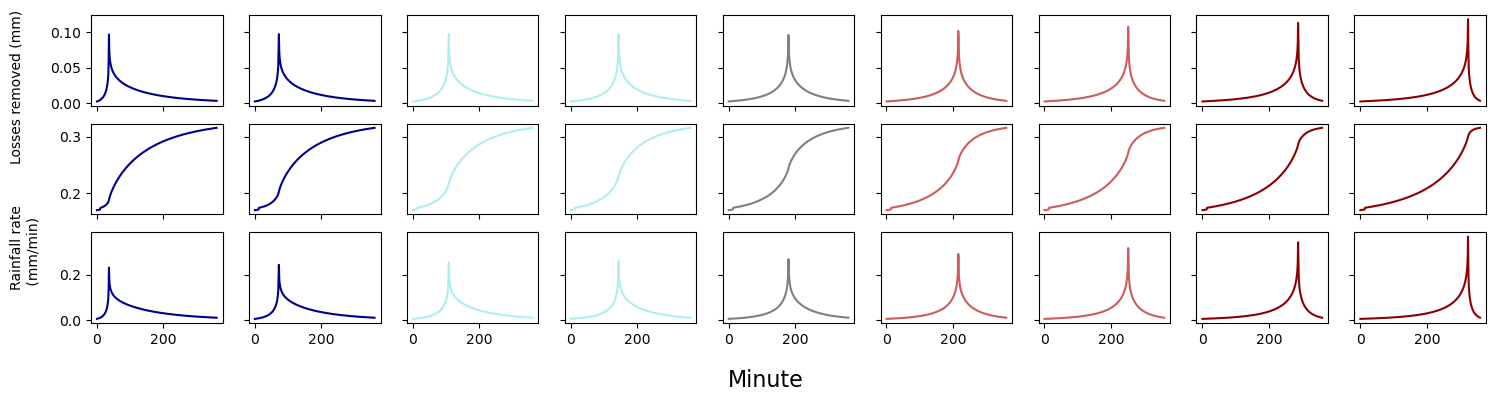

In [31]:
# Create figure
fig, axes = plt.subplots(3, len(methods), figsize=(18,4), sharex =True, sharey = 'row')

for axes_number, method in enumerate(methods):
    pre_loss_removal = pd.read_csv('../IdealisedProfiles/' + "6hr_100yrRP/PreLossRemoval/{}.csv".format(method), names = ['Time', 'Rainfall'])
    post_loss_removal = pd.read_csv('../IdealisedProfiles/' + "6hr_100yrRP/PostLossRemoval/{}_urban.csv".format(method))
    
    post_loss_removal = clean_dfs(post_loss_removal)
    post_loss_removal['losses'] =(post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model']/post_loss_removal['Observed rainfall - 01/08/2022 00:00'])   

    # Plot pre loss removal rainfall
    axes[0, axes_number].plot(np.array(range(360))+0.5, post_loss_removal['Urban net rain mm (Observed rainfall - 01/08/2022) - urbanised model'], color = colors[axes_number])
    # plot the amount of losses remove
    axes[1, axes_number].plot(np.array(range(360))+0.5, post_loss_removal['losses'], color = colors[axes_number])
#     axes[0, axes_number].set_ylabel("Cumulative rainfall")
    # plot the post loss removal rate
    axes[2, axes_number].plot(np.array(range(360))+0.5, post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'], color = colors[axes_number])
#     axes[1, axes_number].set_ylabel("Rainfall rate")
    
fig.text(0.5, -0.05, 'Minute', ha='center', size =16);
fig.text(0.08, 0.7, 'Losses removed (mm)', va='center', rotation='vertical', size = 10);
# fig.text(0.08, 0.7, 'Cumulative\n rainfall (mm)', va='center', rotation='vertical', size = 10);
fig.text(0.08, 0.3, 'Rainfall rate\n (mm/min)', va='center', rotation='vertical', size = 10);    

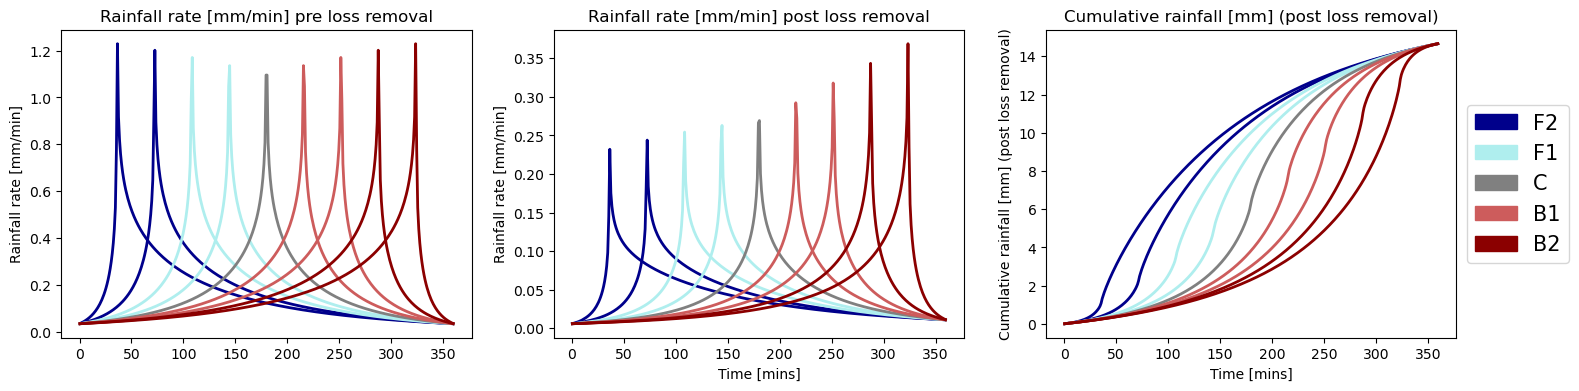

In [36]:
fig, axes = plt.subplots(1, 3,figsize=(18,4), sharex =True, sharey = False)
colors = ['darkblue']*2 + ['paleturquoise']*2 + ['grey']+ ['indianred']*2+['darkred']*2
for axes_number, method in enumerate(methods):
  
    pre_loss_removal = pd.read_csv('../IdealisedProfiles/' + "6hr_100yrRP/PreLossRemoval/{}.csv".format(method), names = ['Time', 'Rainfall'])
    post_loss_removal = pd.read_csv('../IdealisedProfiles/' + "6hr_100yrRP/PostLossRemoval/{}_urban.csv".format(method))
    
    # Reformat
    post_loss_removal = clean_dfs(post_loss_removal)
    post_loss_removal['cumulative_rainfall_this_min'] = post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'].cumsum()
    
    # Plot pre loss removal rainfall rate
    axes[0].plot(np.array(range(360))+0.5,pre_loss_removal['Rainfall'], color=colors[axes_number], linewidth = 2)   
    axes[0].set_ylabel('Rainfall rate [mm/min]')
    axes[0].set_title('Rainfall rate [mm/min] pre loss removal')
    
    # Plot post loss removal rainfall rate
    axes[1].plot(np.array(range(360))+0.5,post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'], color=colors[axes_number], linewidth = 2)   
    axes[1].set_xlabel('Time [mins]')
    axes[1].set_ylabel('Rainfall rate [mm/min]')
    axes[1].set_title('Rainfall rate [mm/min] post loss removal')
    
    # Plot cumulative rainfall rate
    axes[2].plot(np.array(range(360))+0.5,post_loss_removal['cumulative_rainfall_this_min'], color=colors[axes_number], linewidth = 2)   
    axes[2].set_xlabel('Time [mins]')
    axes[2].set_ylabel('Cumulative rainfall [mm] (post loss removal)')
    axes[2].set_title('Cumulative rainfall [mm] (post loss removal)')
    
    
colors_leg = ['darkblue', 'paleturquoise', 'grey', 'indianred', 'darkred']
texts = ['F2','F1','C', 'B1', 'B2'] 
patches = [ mpatches.Patch(color=colors_leg[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.15, 0.5), loc='center', ncol=1, prop={'size': 15} );    

## Check whether total rainfall volume is conserved

In [34]:
for method in methods:
    if method == '6h_single-peak':
        method = '6h_sp_c_0.5'
    print(method)
    pre_loss_removal = pd.read_csv('../IdealisedProfiles/6hr_100yrRP/PreLossRemoval/{}.csv'.format(method), names =['Time', 'Rain'])
    post_loss_removal = pd.read_csv('../IdealisedProfiles/6hr_100yrRP/PostLossRemoval/{}_urban.csv'.format(method))
    
    print("Max rainfall (after loss removal): ", round(post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'].max(),2))
    print("Max rainfall (before loss removal): ", round(pre_loss_removal['Rain'].max(),2))
    
    print("Total event rainfall (after loss removal): ", round(post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'].sum(),1))
    print("Total event rainfall (before loss removal): ", round(pre_loss_removal['Rain'].sum(),2))

6h_sp_fl_0.1
Max rainfall (after loss removal):  0.23
Max rainfall (before loss removal):  1.23
Total event rainfall (after loss removal):  14.7
Total event rainfall (before loss removal):  59.98
6h_sp_fl_0.2
Max rainfall (after loss removal):  0.24
Max rainfall (before loss removal):  1.2
Total event rainfall (after loss removal):  14.7
Total event rainfall (before loss removal):  59.98
6h_sp_fl_0.3
Max rainfall (after loss removal):  0.25
Max rainfall (before loss removal):  1.17
Total event rainfall (after loss removal):  14.7
Total event rainfall (before loss removal):  59.98
6h_sp_fl_0.4
Max rainfall (after loss removal):  0.26
Max rainfall (before loss removal):  1.14
Total event rainfall (after loss removal):  14.7
Total event rainfall (before loss removal):  59.98
6h_sp_c_0.5
Max rainfall (after loss removal):  0.27
Max rainfall (before loss removal):  1.1
Total event rainfall (after loss removal):  14.7
Total event rainfall (before loss removal):  59.98
6h_sp_bl_0.6
Max rainfa